# **Understanding People Faces with Data Science**
**OpenU Data Science Project**

Rafael Balaish - 308071059

Oded Gottesman - 313134553

## **Goal**

Our goal in this project is to detect age and gender of a person from a picture of his/hers face. We are going to use neural networks in order to train our model to classify age and gender. This application may help for targeting untagged profile pictures for advertising purposes, detect potential clients in malls, security cameras automatic alerts, and these are only a few examples for possible uses.

Our stretch goal is to identify a person's emotion by the look on his/hers face. This label can be be useful for marketing (figuring out if the customer is happy during the visit), and also security industries.

**DataSets**

We are going to use [UTKFace](https://susanqq.github.io/UTKFace/) dataset for age and gender classification. We are going to use the "aligned & cropped Faces" dataset.

The second dataset we are going to use for emotion detection is [Facial Expression Recognition(FER)Challenge](https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge?)



# Exploring UTKFace Dataset
The photos are labeled in their names in the following way:
*age_gender_race_datetime*

**Age** - an integer from **0** to **116**, indicating the actual age of the person in the photo.

**Gender** - either 0 or 1. **0** stands for **male**, **1** stands for **female**.

**Race** - an integer between 0 and 4.
  **0** - White
  **1** - Black
  **2** - Asian
  **3** - Indian
  **4** - Other (such as Hispanic, Latino, Middle Eastern...)

**Date & Time** - the date and time the image was collected to the UTKFace dataset, presented in the next format: *yyyymmddHHMMSSFFF*

In [0]:
import os

path = "/tmp/UTKFace_dataset_clean/UTKFace/"
files = os.listdir(path)
size = len(files)

print("Example for a file name:", files[0])
print("Total samples:", size)

Example for a file name: 26_0_1_20170113134355472.jpg.chip.jpg
Total samples: 23669



## Clean the data

1. We found that there are **3** images with wrong name convention (missing labels), so we ignore those samples (can be seen in the catch clause in the next code cell).

2. During the process of training our model, we saw that there are wrong age labeled examples. So we went over them manually, and removed those photos, then reloaded our clean dataset. Because we don't know the actual age, we removed only the extreme obvious wrong sample, e.g. a baby that was labeled as 80 year old...
During this stage we removed **39** samples.

** After we went over all the samples manually, we must confess that it's not an easy mission, we could not classify all samples correctly :)





In [0]:
AGE_INDEX = 0
GENDER_INDEX = 1
RACE_INDEX = 2

images = []
ages = []
genders = []
races = []

for filename in files:
    try: 
      split_var = filename.split('_')
      races.append(int(split_var[RACE_INDEX]))
      ages.append(int(split_var[AGE_INDEX]))
      genders.append(int(split_var[GENDER_INDEX]))

    except ValueError:
      #ignore missing race label (clean data)
      os.remove(path+filename)
      continue    

**Wrong label examples**


<img src="https://i.ibb.co/2dyWG9k/dataset-wrong-labels.png" alt="dataset-wrong-labels" border="0">

## Looking at the distribution of ages in our dataset samples

Max age: 116
Min age: 1


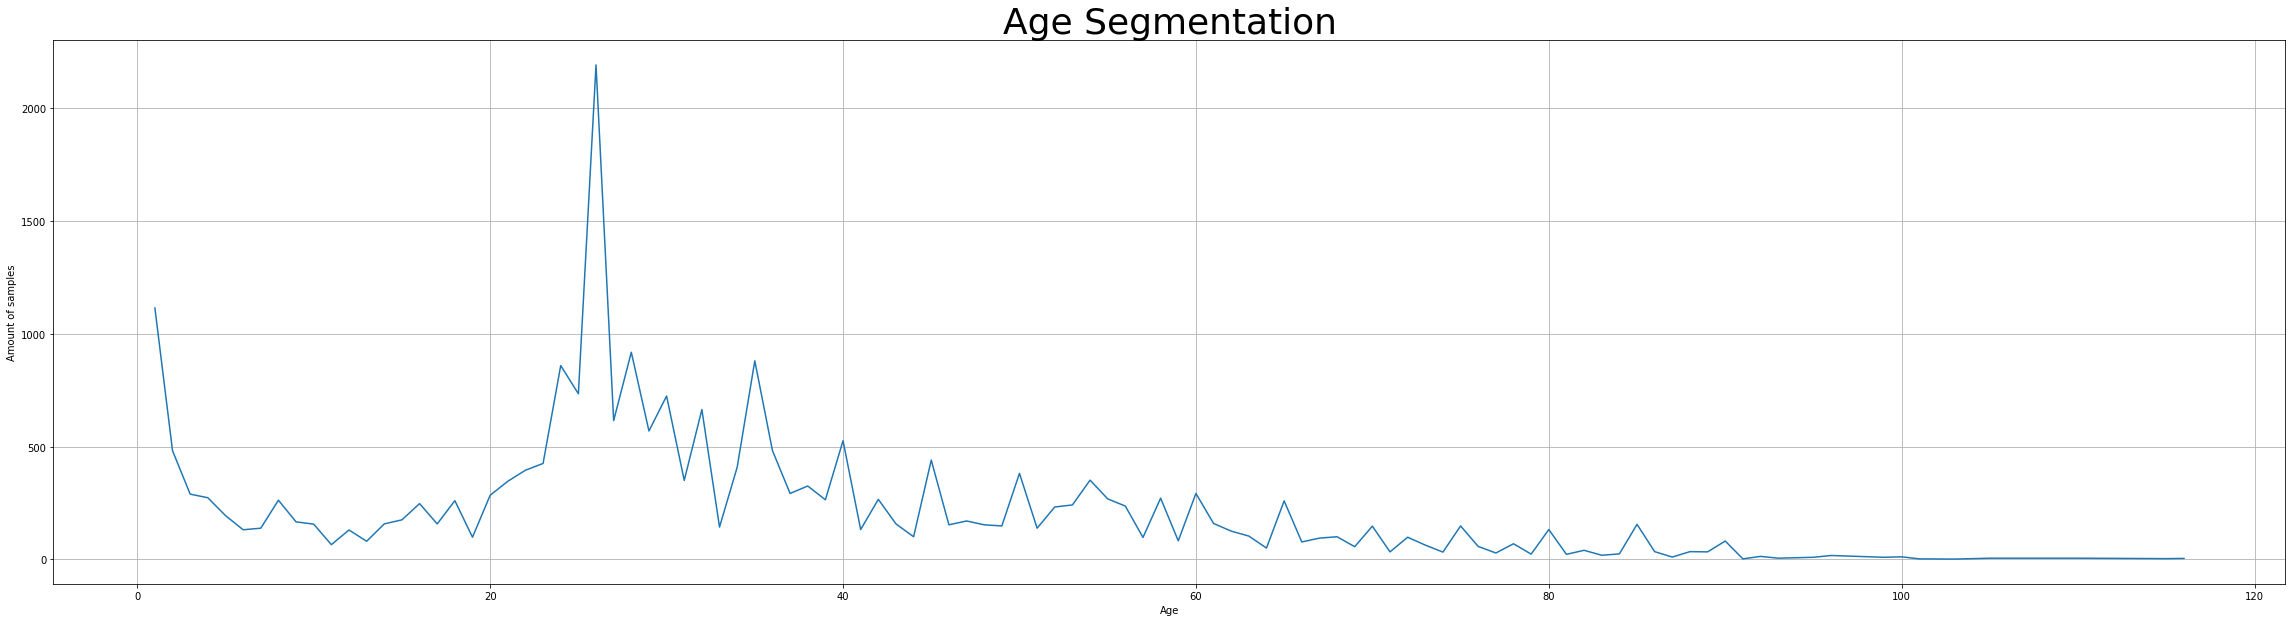

In [0]:
import matplotlib.pyplot as plt

x_ages = list(set(ages))
y_ages_count = [ages.count(i) for i in x_ages]
plt.figure(figsize=(40, 10))
plt.plot(x_ages, y_ages_count)
plt.title("Age Segmentation", fontsize=36) 
plt.xlabel("Age") 
plt.ylabel("Amount of samples") 

plt.grid()

print("Max age:",max(ages))
print("Min age:",min(ages))

We can see the age segmentation of our dataset in the graph. Our concern is that we don't have enough samples of older ages and teenage periods. We assume it will affect our accuracy of an age prediction model.

## Looking at the distribution of genders in our dataset samples

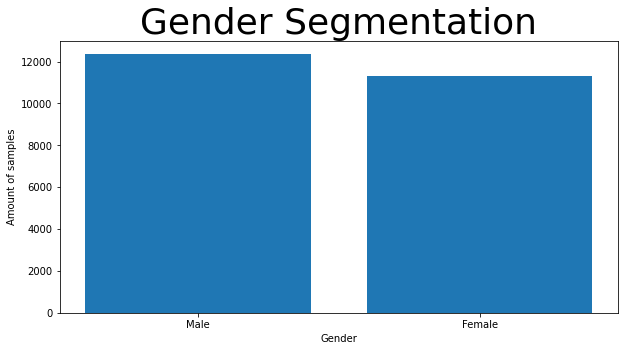

In [0]:
x_genders = list(set(genders))
y_genders_count = [genders.count(i) for i in x_genders]

plt.figure(figsize=(10, 5))
plt.bar(x_genders, y_genders_count)
plt.title("Gender Segmentation", fontsize=36) 
plt.xlabel("Gender") 
plt.ylabel("Amount of samples") 
plt.xticks(x_genders, ['Male', 'Female'])

plt.show()

We can see that we have a quite equal amount of male/female samples, which is good for our gender classification mission.

## Looking at the distribution of races in our dataset samples

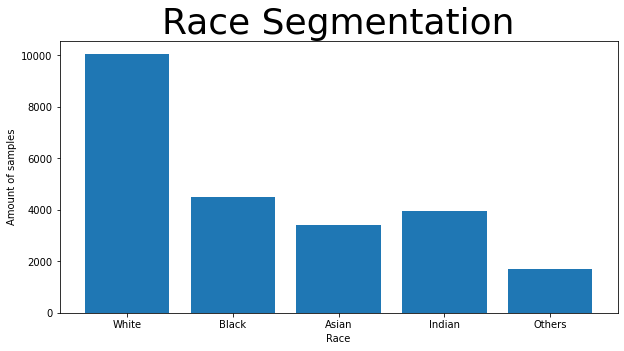

In [0]:
x_races = list(set(races))
y_races_count = [races.count(i) for i in x_races]

plt.figure(figsize=(10, 5))
plt.bar(x_races, y_races_count)
plt.title("Race Segmentation", fontsize=36) 
plt.xlabel("Race") 
plt.ylabel("Amount of samples") 
plt.xticks(x_races, ['White', 'Black', 'Asian', 'Indian', 'Others'])

plt.show()

We do not know if we will use the race label in our model, but we can see that the dataset contains mostly white people photos, other than that the other races are pretty equally distributed. This still might be an issue - our model might classify white people in a better accuracy than other races.

# POC - Classifiying Age

We are going to divide the ages into the next age groups:

**Toddlers:** 0 - 5

**Children:** 5 - 13

**Teenagers:** 13 - 18

**Young:** 18 - 27

**Adults:** 27 - 40

**Middle Age:** 40 - 60

**Old:** 60 - 75

**Very Old:** 75 and older


We are going to use the fastai library in order to try and predict age by a face-photo. fastai gives us an easy api to use neural networks (among the rest), and declares pretty good performance and accuracy as well.

In [0]:
import fastai
import fastai.vision as fav
import numpy as np

Some code to help us divide the photos to age groups, and extract this age group label from the photo name:

In [0]:
def age_to_age_group(age):
  if (age < 5):
    return 0
  elif (age < 13):
    return 1
  elif (age < 18):
    return 2
  elif (age < 27):
    return 3
  elif (age < 40):
    return 4
  elif (age < 60):
    return 5
  elif (age < 75):
    return 6
  else:
    return 7


AGE_GROUP_IDX_TO_LABEL = {
    0: "Toddler",
    1: "Child",
    2: "Teenager",
    3: "Young",
    4: "Adult",
    5: "Middle Aged",
    6: "Old",
    7: "Very Old"
}

def extract_age(filename):
  return int(filename.stem.split('_')[AGE_INDEX])

def extract_age_group(filename):
  return age_to_age_group(extract_age(filename))

def extract_age_label(filename):
  return AGE_GROUP_IDX_TO_LABEL[extract_age_group(filename)]

We will now load the data into an ImageList fastai object, and use the fastai transform method to enrich our photos with more angles of each photo.
We are splitting the dataset here by a factor of 0.2: 20% of the photos will be used for the validation set, the other 80% will be our training set.

In [0]:
path = fav.Path('/tmp/UTKFace_dataset_clean/UTKFace')
tfms = fav.get_transforms(do_flip = False)
data = fav.ImageList.from_folder(path).split_by_rand_pct(0.2, seed = 171).label_from_func(extract_age_label).transform(tfms).databunch().normalize(fastai.vision.imagenet_stats)

Lets look at some of the photos and their lables:

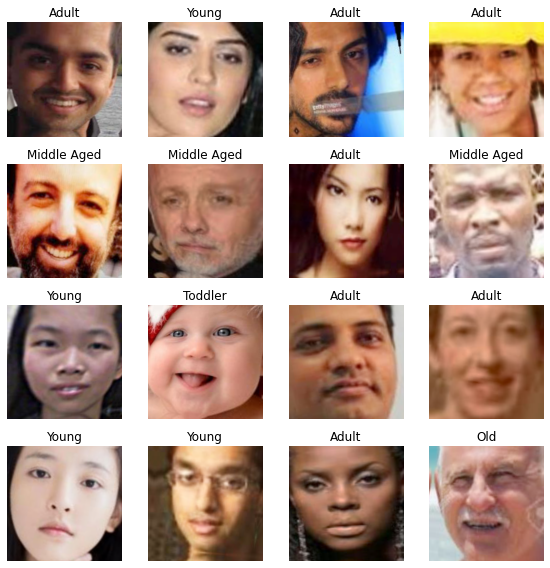

In [0]:
data.show_batch(rows = 4, figsize = (8,8))

In [0]:
data.classes

['Adult',
 'Child',
 'Middle Aged',
 'Old',
 'Teenager',
 'Toddler',
 'Very Old',
 'Young']

Now we are ready to feed our dataset into a learner object. We will use a CNN as it seems as a classic easy model for image-classification problems. We will start with a pre-defined resnet34 model which fastai allows to use easily.

In [0]:
age_learner = fav.cnn_learner(data, fav.models.resnet34, metrics = fav.accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


We will now use the fit_one_cycle method fastai cnn_learner provides us, to start and train the model. We will start with 5 epochs (rounds of the model going over all of our data, pass it through the network, recalculate weights...)

In [0]:
age_learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.745922,1.327019,0.464399,02:01
1,1.332584,1.182575,0.483203,02:03
2,1.195331,1.101857,0.525248,02:04
3,1.097230,1.066678,0.541094,02:03
4,1.051552,1.052004,0.545531,02:04


Unfurtonately, we are getting pretty bad results.
Starting with 46% accuracy which is disappointing. But we do see a very big improvement over the epochs, 10% increase of accuracy - ending with 54% is still bad but we might be able to improve it later on.

We will save our trained learner just in case we want to go back and use it from the same spot later.

In [0]:
age_learner.save('age-1')

The resnet34 model we used, is a predefined model which was trained on a big dataset of photos of many kinds. The fitting cycles we performed, only trained layers that fastai adds above the model. We will now unfreeze our model, meaning it allows us to train the inner layers as well. We will use the lr_find method to find the best learning rate we can use to train the model fast while maintaining accuracy

In [0]:
age_learner.unfreeze()
age_learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


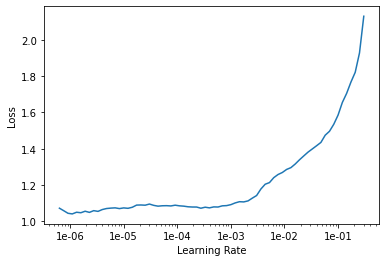

In [0]:
age_learner.recorder.plot()

Seems like a bit before 1e-6 learning rate we are already starting to increase our loss. So we will use this data to config the next fitting cycles:

In [0]:
age_learner.fit_one_cycle(5, slice(((1e-6) / 2), (1e-6)))

epoch,train_loss,valid_loss,accuracy,time
0,1.040047,1.042747,0.547644,02:08
1,1.052489,1.040794,0.552504,02:08
2,1.035519,1.033637,0.550813,02:07
3,1.023372,1.031955,0.555250,02:07
4,1.045055,1.029501,0.553560,02:09


We only managed to increase our accuracy by a bit less than 1%, to 55%..

Lets look at some of our model mistakes:

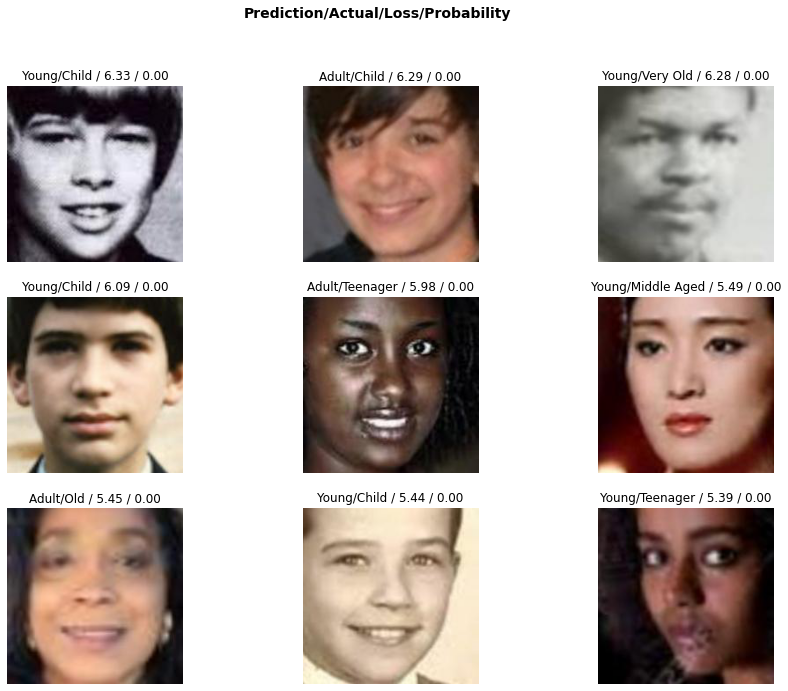

In [0]:
interp = fastai.vision.ClassificationInterpretation.from_learner(age_learner)
interp.plot_top_losses(9, figsize=(15,11))

We can see that some of the worst mistakes (our model was very confident of its prediction, while it was wrong) was on photos of black people, which have less example in this dataset comparing to white people. Also some of the photos are blurry.

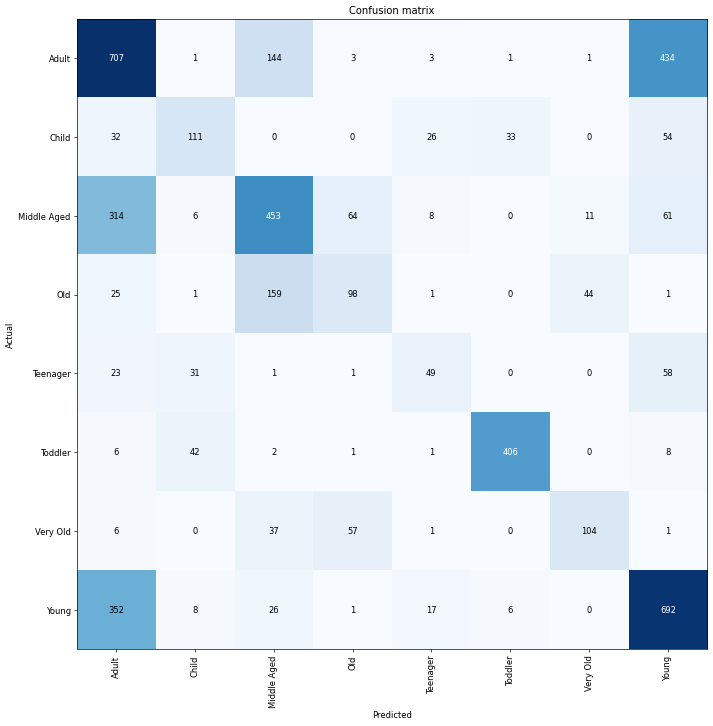

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused()

[('Adult', 'Young', 434),
 ('Young', 'Adult', 352),
 ('Middle Aged', 'Adult', 314),
 ('Old', 'Middle Aged', 159),
 ('Adult', 'Middle Aged', 144),
 ('Middle Aged', 'Old', 64),
 ('Middle Aged', 'Young', 61),
 ('Teenager', 'Young', 58),
 ('Very Old', 'Old', 57),
 ('Child', 'Young', 54),
 ('Old', 'Very Old', 44),
 ('Toddler', 'Child', 42),
 ('Very Old', 'Middle Aged', 37),
 ('Child', 'Toddler', 33),
 ('Child', 'Adult', 32),
 ('Teenager', 'Child', 31),
 ('Child', 'Teenager', 26),
 ('Young', 'Middle Aged', 26),
 ('Old', 'Adult', 25),
 ('Teenager', 'Adult', 23),
 ('Young', 'Teenager', 17),
 ('Middle Aged', 'Very Old', 11),
 ('Middle Aged', 'Teenager', 8),
 ('Toddler', 'Young', 8),
 ('Young', 'Child', 8),
 ('Middle Aged', 'Child', 6),
 ('Toddler', 'Adult', 6),
 ('Very Old', 'Adult', 6),
 ('Young', 'Toddler', 6),
 ('Adult', 'Old', 3),
 ('Adult', 'Teenager', 3),
 ('Toddler', 'Middle Aged', 2),
 ('Adult', 'Child', 1),
 ('Adult', 'Toddler', 1),
 ('Adult', 'Very Old', 1),
 ('Old', 'Child', 1),
 ('O

We can see that the massive amount of mistakes happen between close age groups (adults-middle aged, adults-young, etc) so this isn't very surprising.

We will stop at this point and continue later on, trying to figure out how to improve these results which aren't satisfying. We have a few ideas - dividing our age groups differently, or maybe predict exact age and then divide into age groups. Also possibly train only the last few layers of the model might help, or use a model with more layers.

# POC - Classifiying Gender

The UTKFace dataset labels the photos by gender:

**0** - Male

**1** - Female

We will use fastai to try and predict the gender of a person by a face-photo.
The process is going to be very similar to the age-classifying process.

In [0]:
GENDER_LABEL_TO_TEXT = {
    0: "Male",
    1: "Female"
}

def extract_gender(filename):
  return int(filename.stem.split('_')[GENDER_INDEX])

def extract_gender_text_label(filename):
  return GENDER_LABEL_TO_TEXT[extract_gender(filename)]

Loading the data:

In [0]:
path = fav.Path('/tmp/UTKFace_dataset_clean/UTKFace/')
tfms = fav.get_transforms(do_flip = False)
data = fav.ImageList.from_folder(path).split_by_rand_pct(0.2, seed = 347).label_from_func(extract_gender_text_label).transform(tfms).databunch().normalize(fastai.vision.imagenet_stats)

Lets look at some of the photos and their lables:

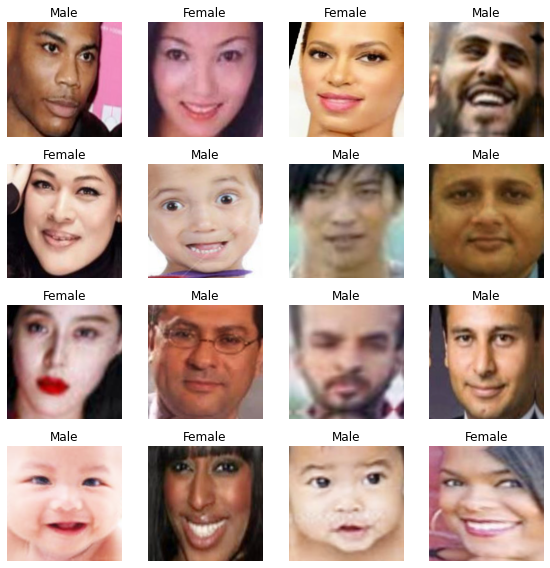

In [0]:
data.show_batch(rows = 4, figsize=(8,8))

And now we will try to train our mode:

In [0]:
gender_learner = fav.cnn_learner(data, fav.models.resnet34, metrics = fav.accuracy)

In [0]:
gender_learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.554012,0.407777,0.823579,02:02
1,0.432499,0.342478,0.851257,01:57
2,0.354702,0.292276,0.872174,01:54
3,0.322736,0.266380,0.885696,01:52
4,0.295837,0.264693,0.889711,01:52


We acheived 88.9% accuracy of predicting our validation set photos gender, after only 5 epochs! Pretty impressing and surprising for the first try. We will now save our acheivment.

In [0]:
gender_learner.save('gender-stage-1')

We will now see if we can make it even better:

In [0]:
gender_learner.unfreeze()
gender_learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


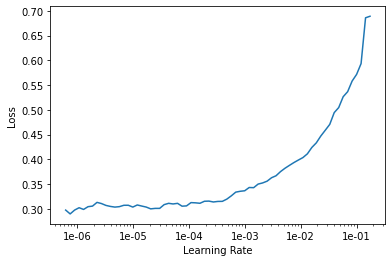

In [0]:
gender_learner.recorder.plot()

In [0]:
gender_learner.fit_one_cycle(3, max_lr = slice(((1e-6) / 2), (1e-6)))

epoch,train_loss,valid_loss,accuracy,time
0,0.287735,0.260299,0.890767,02:05
1,0.281183,0.257263,0.892246,02:08
2,0.278097,0.255417,0.892035,02:07


We acheived 89.2% accuracy! This isn't a very big improvement from our last result but still pretty impressive for our first tries to work with the data. We can notice that the last epoch didn't help - it decreased the accuracy a bit. We might try to investigate that later on.

In [0]:
gender_learner.save("gender-stage-2")

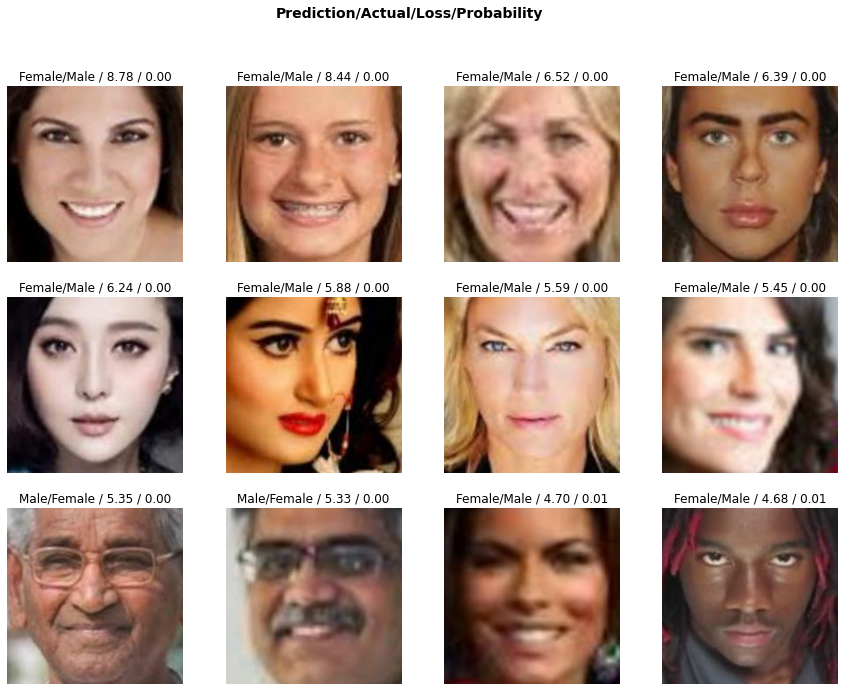

In [0]:
gender_interp = fav.ClassificationInterpretation.from_learner(gender_learner)
gender_interp.plot_top_losses(12, figsize=(15,11))

Looking at our model top mistakes, we can see some obvious mistakes in the dataset itself! Some photos here, which are clear males, are tagged as females, and vice versa as well. We noticed the same thing when we first trained our age-classifier. This isn't shown in this notebook because we cleaned it and retrained the model.

We might have to go through the same process of cleaning our dataset for false labels of genders as well. Also we are looking at more datasets to work with because of these mistakes.

# Conclusion for this point

We managed to get pretty good results with our gender prediction, and pretty bad results with our age prediction. We noticed some mistakes in our dataset labels, some of them we cleaned and some of them we will have to deal with later on.

Next, we plan on trying to improve our accuracy, mainly on the age classifier, and try to combine our work with another dataset that might enrich our diversity of examples.

Also we consider trying to predict people's emition, and maybe combine all of these features into one concept of trying to understand interesting features of people faces.